# TSFM Tutorial

Welcome to the TSFM (Time Series Foundation Models) package tutorial. This notebook will guide you through forecasting with multiple state-of-the-art models.

## 0. Installation

### Create a dedicated conda environment

It's recommended to use a separate conda environment with its own Jupyter kernel to avoid dependency conflicts. The following commands create a new environment named `tsfm` with Python 3.12 and install the `tsfmecb` package, you can run the commands in your terminal:

```bash
conda create -n tsfm python==3.12 ipykernel -y
conda activate tsfm
pip install tsfmecb
python -m ipykernel install --user --name=tsfm --display-name "tsfm"
```

### Select the kernel in Jupyter

After creating the environment, select the `tsfm` kernel in your notebook:

<img src="https://raw.githubusercontent.com/IliasAarab/tsfm/main/docs/img/kernel.png" alt="Kernel Selection" width="50%"/>

Click the kernel selector in the top-right corner of Jupyter Lab and choose **"tsfm"** from the list.

## 1. Introduction

This notebook demonstrates time series forecasting using the `TSFM` library. You'll see how the registry pattern lets you swap models with a single line of code, and how the shared `ForecastOutput` wrapper standardizes evaluation and visualization.

**What you'll learn:**
- Basic forecasting workflow
- Switching between different models (ARModel, Chronos, Moirai)
- Interpreting forecast outputs and metrics

## 2. Load the data

We'll rely on standard scientific Python tools alongside the `tsfm` package. The `Model` registry lets us dynamically build forecasting backends by name, so importing it is enough to access every registered model.

> **Cheat sheet**: `Model` is the abstract base class; concrete implementations like `chronos` and `moirai` register themselves so you can instantiate them by string name. Utilities in `tsfm.data` help you simulate or prepare data, and `tsfm.outputs.ForecastOutput` standardizes evaluation metrics and plots.

In [2]:
import pandas as pd

from tsfm import Model

c:\Mambaforge\envs\uv\projects\tsfm\.venv\Lib\site-packages\lightning\fabric\__init__.py:40: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


## 2. Load and Prepare Data

We'll start from the provided macroeconomic panel. We coerce the index to month-end timestamps so every model sees the same calendar. Feel free to swap in your own DataFrame, as long as the index is a ordered (from past to recent) `DatetimeIndex`, the downstream helpers will work unchanged.

In [3]:
url = "https://raw.githubusercontent.com/IliasAarab/tsfm/refs/heads/main/data/data.csv"
cols_to_drop = "Negotiated wages including"
df = pd.read_csv(url).dropna().rename(columns={"Unnamed: 0": "dt"})
df["dt"] = pd.to_datetime(df["dt"], format="%Y%b").add(pd.offsets.MonthEnd(0))
df.index = df.pop("dt")
df = df.drop(cols_to_drop, axis=1).astype(float).sort_index()

## 2.1 Input Data Format Requirements

All models in `tsfm` expect data in a specific format:

### Required Format:
1. **DataFrame with DatetimeIndex**: Your data must be a `pandas.DataFrame` with a `DatetimeIndex`
2. **Ordered chronologically**: Index must be sorted from past to present
3. **Regular frequency**: The index should have a consistent frequency (monthly, quarterly, weekly, etc.)
4. **No missing timestamps**: The time series should be complete (no gaps in the index)

### Automatic Frequency Detection:
The library automatically detects your data's frequency using `pd.infer_freq()`:
- **Monthly (M)**: Data at month-end dates (e.g., 2020-01-31, 2020-02-29)
- **Quarterly (Q)**: Data at quarter-end dates (e.g., 2020-03-31, 2020-06-30)
- **Weekly (W)**: Data at week-end dates
- **Daily (D)**: Daily observations
- **Custom**: Any valid pandas frequency string

### Example of Proper Format:
```python
# ✅ Good: DatetimeIndex with regular frequency
df.index = pd.date_range('2000-01-31', periods=100, freq='M')

# ✅ Good: Quarterly data
df.index = pd.date_range('2000Q1', periods=40, freq='Q')

# ❌ Bad: String index
df.index = ['2000-01', '2000-02', ...]  # Must be DatetimeIndex

# ❌ Bad: Unordered dates
df = df.sample(frac=1)  # Must be sorted chronologically
```

### Column Structure:
- **Target variable**: Single column with the values you want to forecast (specified by `y` parameter)
- **Covariates (optional)**: Additional columns that can help predict the target (specified by `X` parameter)
- Note: Not all models support covariates (e.g., `armodel` and `chronos` do not)

### Data Preparation Tips:
- Use `.sort_index()` to ensure chronological order
- Use `.resample()` to change frequency (e.g., from weekly to monthly)
- Handle missing values before forecasting (`.dropna()` or `.fillna()`)
- Ensure numeric data types for all forecast columns

### Validate the loaded data format

Let's verify our DataFrame meets all requirements:

In [4]:
print("✓ Data Format Validation")
print("=" * 50)

# Check 1: Is index a DatetimeIndex?
print(f"1. DatetimeIndex: {isinstance(df.index, pd.DatetimeIndex)}")

# Check 2: Is data sorted chronologically?
print(f"2. Sorted: {df.index.is_monotonic_increasing}")

# Check 3: Detect frequency
freq = pd.infer_freq(df.index)
print(f"3. Detected frequency: {freq}")

# Check 4: Check for missing values
print(f"4. Missing values: {df.isna().sum().sum()} cells")

# Check 5: Date range
print(f"5. Date range: {df.index.min()} to {df.index.max()}")
print(f"6. Total observations: {len(df)}")

print("\n✓ All checks passed! Data is ready for forecasting.")

✓ Data Format Validation
1. DatetimeIndex: True
2. Sorted: True
3. Detected frequency: M
4. Missing values: 0 cells
5. Date range: 1992-01-31 00:00:00 to 2025-07-31 00:00:00
6. Total observations: 403

✓ All checks passed! Data is ready for forecasting.


### Peek at the panel

In [5]:
display(df.head())
df.describe().T.assign(non_null=df.notna().sum(), missing=df.isna().sum())

,Negotiated wages excluding,HICP overall index,Price trends over next 12 months,Economic sentiment,Unemployment expectation over the next 12 months,Unemployment rate,Industrial production
dt,,,,,,,
1992-01-31,8.93,68.90,57.8,94.1,33.1,6.019721,81.1
1992-02-29,8.67,69.14,60.0,93.2,34.8,6.086864,81.9
1992-03-31,7.46,69.42,59.8,90.6,36.7,6.171593,80.0
1992-04-30,9.68,69.66,61.9,88.6,38.9,6.276541,79.9
1992-05-31,12.42,69.84,63.0,87.5,40.3,6.393789,79.0


,count,mean,std,min,25%,50%,75%,max,non_null,missing
Negotiated wages excluding,403.0,2.753474,1.817749,0.500000,1.860000,2.310000,2.860000,12.420000,403,0
HICP overall index,403.0,92.588015,15.829927,68.900000,78.650000,91.400000,101.700000,131.900000,403,0
Price trends over next 12 months,403.0,36.437221,13.126842,-0.100000,26.050000,35.900000,45.600000,66.700000,403,0
Economic sentiment,403.0,98.980397,10.285056,66.800000,92.250000,101.000000,106.500000,118.300000,403,0
Unemployment expectation over the next 12 months,403.0,29.111166,17.246149,-2.800000,16.200000,26.700000,42.900000,78.400000,403,0
Unemployment rate,403.0,6.551615,2.541322,2.857827,3.836402,7.080518,8.546397,11.237894,403,0
Industrial production,403.0,91.895782,11.029378,69.800000,82.950000,93.500000,101.800000,111.100000,403,0


### Visualize the target

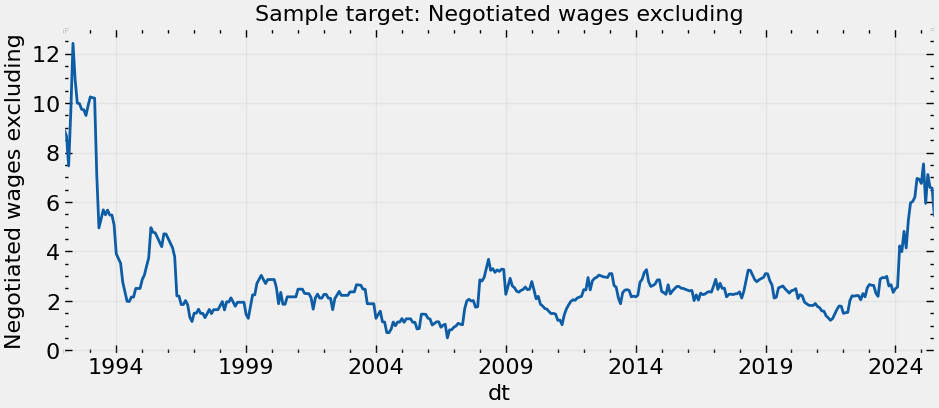

In [6]:
target = df.columns[0]
ax = df[target].plot(figsize=(10, 4), title=f"Sample target: {target}")
ax.set_ylabel(target)
ax.grid(True, alpha=0.3)

## 3. (Optional) Simulate synthetic data

If you want to experiment without the macro panel, the `tsfm.data.generator` function can synthesize autoregressive monthly data with trend and seasonality. The helper returns a tidy DataFrame ready for any model.

In [7]:
from tsfm.data import generator, split_is_oos

synthetic = generator(n=120, seed=42)
syn_is, syn_oos = split_is_oos(synthetic, test_frac=0.2)
syn_is.tail(), syn_oos.head()

(                   x         y
 2007-08-31 -0.423298  1.278021
 2007-09-30 -0.079718  0.330093
 2007-10-31 -1.687334  0.440215
 2007-11-30 -1.447112  0.066509
 2007-12-31 -1.322700  1.248471,
                    x         y
 2008-01-31 -0.997247  1.293991
 2008-02-29  0.399774  1.956589
 2008-03-31 -0.905479  2.802947
 2008-04-30 -0.378163  3.609860
 2008-05-31  1.299228  4.749641)

## 4. Build Models and Generate Predictions

The `Model.build()` factory consults the registry populated by each subclass. We'll start with Salesforce's `moirai` foundation model, which supports covariates and longer horizons. You can swap the `mdl_name` to `armodel` for a lightweight autoregressive baseline.

### Model Selection Guide

| Model | Covariates | Speed  | Best For |
|-------|-----------|-------|----------|
| `armodel` | ❌ | ⚡⚡⚡ | Quick baseline, fast prototyping |
| `chronos` | ❌ | ⚡⚡ | Fast univariate forecasting |
| `chronos2` | ✅ | ⚡⚡ | Multivariate forecasting |
| `moirai` | ✅ | ⚡⚡ |  Multivariate forecasting |
| `moirai2` | ✅ | ⚡⚡ |  Multivariate forecasting |


### Forecast with the Moirai foundation model

Moirai handles multivariate contexts and longer horizons. We select a target column, pass the remaining columns as covariates, and request a 12-month forecast horizon starting in 2020.

In [8]:
mdl_name = "chronos2"  # "armodel" "moirai" "moirai2" "chronos" "chronos2"
mdl = Model.build(name=mdl_name)

y = "Negotiated wages excluding"
X = list(df.columns[1:])
oos_start = "2020-01-31"
res = mdl.pred(df=df, y=y, X=X, ctx_len=120, horizon=12, oos_start=oos_start)
res

Building chronos2... chronos2 has been build!
chronos2 has been build!


================== Forecast Results Summary ==================
Observations: 672
Cutoff range : 2019-12-31  -  2024-07-31
OOS range    : 2020-01-31  -  2025-07-31
Horizons     : 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12
Meta         : model=chronos2 | oos_start=2020-01-31 | freq=M
--------------------------------------------------------------
         rmsfe    mae     me
horizon                     
1       0.3832 0.2308 0.1078
2       0.5336 0.3337 0.1871
3       0.6907 0.4436 0.2680
4       0.8477 0.5563 0.3513
5       1.0086 0.6567 0.4358
6       1.1408 0.7543 0.5074
7       1.2953 0.8536 0.6006
8       1.4201 0.9287 0.6617
9       1.5384 1.0240 0.7643
10      1.6728 1.1094 0.8475
11      1.7728 1.1950 0.9439
12      1.8612 1.2669 1.0185
average 1.1804 0.7794 0.5578

### Baseline forecast with the autoregressive model

For a fast baseline, the `armodel` implementation trains a rolling autoregressive process $AR(1)$ of order `ctx_len`. It only consumes the target column, so we set `X=None` and keep a short context window.

In [9]:
arm = Model.build(name="armodel")
arm_res = arm.pred(df=df[[y]].copy(), y=y, X=None, ctx_len=4, horizon=6, oos_start=oos_start)
arm_res

Building armodel... armodel has been build!


================== Forecast Results Summary ==================
Observations: 372
Cutoff range : 2019-12-31  -  2025-01-31
OOS range    : 2020-01-31  -  2025-07-31
Horizons     : 1, 2, 3, 4, 5, 6
Meta         : model=armodel | oos_start=2020-01-31 | freq=M
--------------------------------------------------------------
         rmsfe    mae     me
horizon                     
1       0.4396 0.2656 0.1015
2       0.5807 0.3838 0.1947
3       0.7884 0.5254 0.3016
4       0.9408 0.6400 0.3882
5       1.0871 0.7236 0.4752
6       1.2037 0.7819 0.5297
average 0.8400 0.5534 0.3318

## 5. Analyze Results

Every forecast returns a `ForecastOutput`. It stores the multi-horizon panel in `df_preds` and offers cached metrics so you can compare models quickly. Below we print the text summary and then pull metric tables directly for ad-hoc analysis.

In [10]:
res.summary()

================== Forecast Results Summary ==================
Observations: 672
Cutoff range : 2019-12-31  -  2024-07-31
OOS range    : 2020-01-31  -  2025-07-31
Horizons     : 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12
Meta         : model=chronos2 | oos_start=2020-01-31 | freq=M
--------------------------------------------------------------
         rmsfe    mae     me
horizon                     
1       0.3832 0.2308 0.1078
2       0.5336 0.3337 0.1871
3       0.6907 0.4436 0.2680
4       0.8477 0.5563 0.3513
5       1.0086 0.6567 0.4358
6       1.1408 0.7543 0.5074
7       1.2953 0.8536 0.6006
8       1.4201 0.9287 0.6617
9       1.5384 1.0240 0.7643
10      1.6728 1.1094 0.8475
11      1.7728 1.1950 0.9439
12      1.8612 1.2669 1.0185
average 1.1804 0.7794 0.5578


### Compare metrics side by side

Each metric is a cached property. You can access them individually or stack them for comparison. The example below collects MAE and RMSFE for both models to benchmark alternatives.

In [11]:
metrics = pd.concat({"chronos2": res.mae["mae"], "armodel": arm_res.mae["mae"]}, axis=1)
metrics.index.name = "horizon"
metrics

,chronos2,armodel
horizon,,
1,0.230774,0.265615
2,0.333715,0.383792
3,0.443616,0.525381
4,0.556343,0.640048
5,0.656731,0.723597
6,0.754298,0.781941
7,0.853647,NaN
8,0.928665,NaN
9,1.024011,NaN


### Inspect the underlying forecast panel

`ForecastOutput.df_preds` is a tidy MultiIndex DataFrame keyed by cutoff and out-of-sample date. This makes it easy to filter by horizon or time slices.

In [12]:
res.df_preds.head()

y_true    y_pred  quantile_0.1  quantile_0.2  \
cutoff     oos_date                                                   
2019-12-31 2020-01-31    2.41  2.402069      2.206605      2.268696   
           2020-02-29    2.43  2.443603      2.126665      2.238027   
           2020-03-31    2.49  2.476799      2.073042      2.212744   
           2020-04-30    2.09  2.473325      2.004294      2.173127   
           2020-05-31    2.25  2.433161      1.917420      2.100093   

                       quantile_0.3  quantile_0.4  quantile_0.5  quantile_0.6  \
cutoff     oos_date                                                             
2019-12-31 2020-01-31      2.317442      2.361299      2.402069      2.444235   
           2020-02-29      2.317058      2.382811      2.443603      2.506579   
           2020-03-31      2.312148      2.397181      2.476799      2.558867   
           2020-04-30      2.287217      2.383104      2.473325      2.565679   
           2020-05-31      2.225193      2.332477      2.433161      2.537155   

                       quantile_0.7  quantile_0.8  quantile_0.9  
cutoff     oos_date                                              
2019-12-31 2020-01-31      2.486597      2.540344      2.619766  
           2020-02-29      2.572004      2.652802      2.764777  
           2020-03-31      2.642811      2.746050      2.884786  
           2020-04-30      2.662861      2.782219      2.945082  
           2020-05-31      2.644827      2.777781      2.958258

### Plot a specific horizon

`ForecastOutput.plot_actual_vs_pred()` visualizes the out-of-sample trajectory for a given horizon. Try tweaking the `horizon`, `start`, or `end` arguments to focus on different segments.

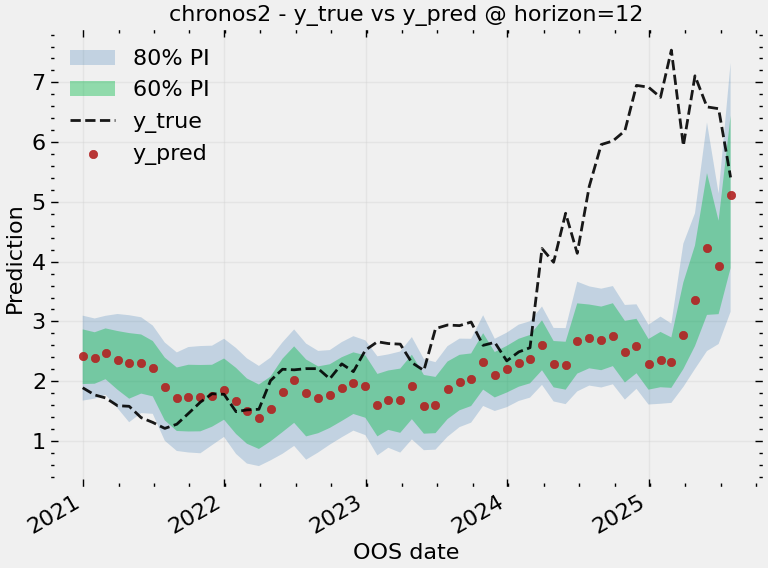

In [14]:
res.plot_actual_vs_pred(horizon=12)

## 6. Where to go next

- Swap `mdl_name` to other registered models (or register your own) and reuse the same evaluation cells.
- Increase `horizon` or adjust `ctx_len` to study the impact on Moirai vs. ARModel.
- Pipe `ForecastOutput.df_preds` into your favorite analysis toolkit.

## 7. Troubleshooting

### Common issues and solutions

**Empty `y_true` column in predictions:**
- **Cause:** Your cutoff dates don't align with actual data timestamps
- **Solution:** Ensure your data has a proper `DatetimeIndex` with consistent frequency. The package automatically normalizes timestamps, but irregular data can cause misalignment.

**Frequency inference warnings:**
- **Cause:** Irregular time series or insufficient data points
- **Solution:** Ensure at least 3 observations per series. For irregular data, resample to a regular frequency first using `df.resample('M').mean()` or similar.